In [117]:
# test fft
from numpy.fft import fftshift, ifftshift, fftn, ifftn
import scipy.misc as misc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


In [131]:

def build_mask(shape, ratio, subsampling_type='hf_focused', center_fraction=0.1):
    """ Create the mask that removes rows
        1 indicates the pixel is known during training.
        Expected shape is: 1 x height x width x 2
    """
    #pdb.set_trace()
    np.random.seed(0)
#     ratio = 4
    img_mask_np = np.zeros(shape) #img_fft_np.copy()
    nrows = shape[1]

#     center_fraction = 0.2 #0.078125
    
    # Just simplfies the implementation
    if not float(ratio).is_integer():
        raise Exception("Subsampling ratio should be integral")

    # For random methods
    nrows_keep = int(nrows/ratio)
    inds = np.random.choice(nrows, size=nrows_keep, replace=False)

    # For center masking methods
    radius = int(nrows*center_fraction/2)
    print('radius', radius)
    middle = int(nrows/2)
    non_center_inds = (
        list(range(radius, middle-radius)) +
        list(range(middle+radius, nrows-radius)))
    non_center_subsample = list(set(inds) & set(non_center_inds))

    if subsampling_type == "random":
        img_mask_np[:,inds,:,:] = 1
    elif subsampling_type == "hf_focused":
        # region around center of image should be all 1
        # region around either end should be all 0
        img_mask_np[:,(middle-radius):(middle+radius),:,:] = 1
        img_mask_np[:,non_center_subsample,:,:] = 1
    elif subsampling_type == "lf_focused":
        # region around center of image should be all 0
        # region around either end should be all 1

        ## Want low frequences, which are near the top and bottom
        img_mask_np[:,:radius,:,:] = 1
        img_mask_np[:,(-radius):,:,:] = 1
        img_mask_np[:,non_center_subsample,:,:] = 1
    elif subsampling_type == "alternating_plus_hf":
        img_mask_np[:,::ratio,:,:] = 1
        img_mask_np[:,(middle-radius):(middle+radius),:,:] = 1
        img_mask_np[:,:radius,:,:] = 0
        img_mask_np[:,(-radius):,:,:] = 0
    elif subsampling_type == "alternating_plus_lf":
        #https://arxiv.org/pdf/1709.02576.pdf
        img_mask_np[:,::ratio,:,:] = 1
        img_mask_np[:,(middle-radius):(middle+radius),:,:] = 0
        img_mask_np[:,:radius,:,:] = 1
        img_mask_np[:,(-radius):,:,:] = 1
    elif subsampling_type == "alternating":
        # Really doesn'y work very well!
        img_mask_np[:,::ratio,:,:] = 1

    return img_mask_np

def gen_kspace_mask(shape, ratio=0.25, mask_low_freqs = 5):
    
    h, w = shape
    mask_fft = (np.random.RandomState(42).rand(h) < ratio).astype(np.float32)
    mask_fft[:mask_low_freqs] = mask_fft[-mask_low_freqs:] = 1
    mask_fft = torch.from_numpy(mask_fft).view(1, h, 1, 1).expand(1,h,w,2)

    return mask_fft


144 144
d.shape torch.Size([1, 128, 128, 2])
torch.FloatTensor
torch.Size([1, 128, 128, 2])
masked_img range -1.1309690475463867-1.0592403411865234


/Users/zizhao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


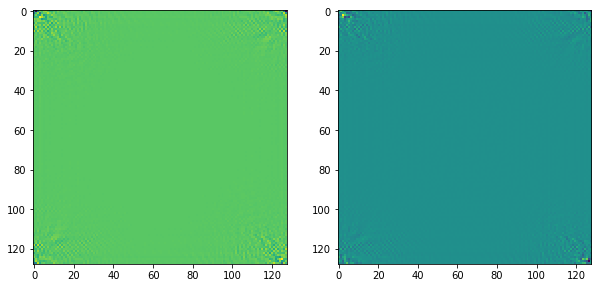

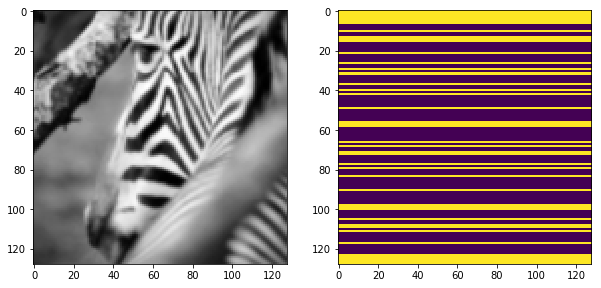

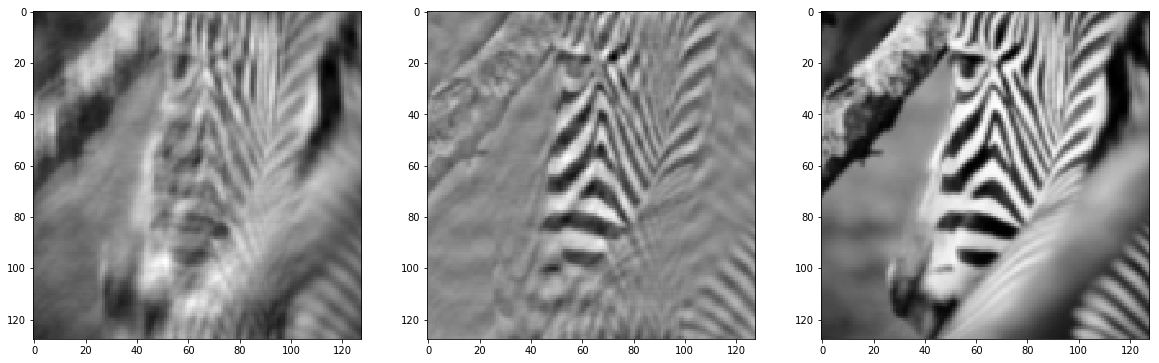

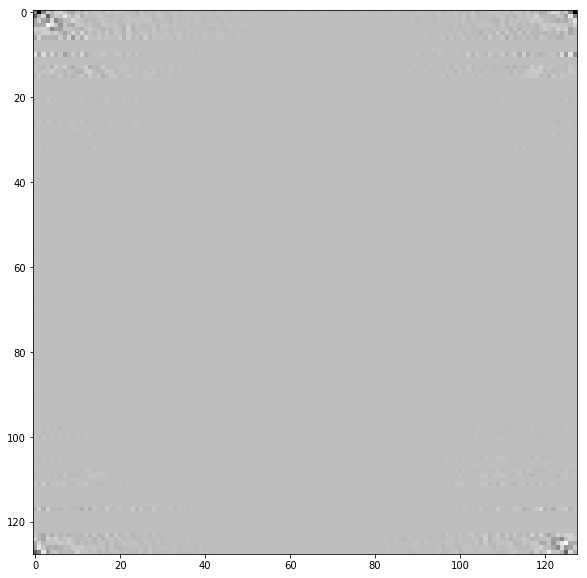

In [142]:
import torch
from scipy.ndimage import gaussian_filter
from PIL import Image
im = Image.open('pics/zebra.jpg').convert('L')
gim = np.asarray(im)
h,w = gim.shape
h, w = 144, 144
print(h, w)
gim = misc.imresize(gim,(h,w)) / 255
gim = gim[8:-8,8:-8]
h, w = 128, 128
im_tensor = torch.from_numpy(gim).float()
im_tensor.mul_(2).add_(-1)
im_tensor.clamp_(-1,1)
# mask = build_mask((1,h,w,2), 4, subsampling_type='lf_focused', center_fraction=0.2).astype(np.float32)
# print('mask size', mask.shape)

mask_fft = gen_kspace_mask([h,w], 0.25)
mask = mask_fft.float().numpy()

d = torch.rfft(im_tensor.view(1,h,w), 2, onesided=False)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(d[0][:,:,0])
plt.subplot(122)
plt.imshow(d[0][:,:,1])
print('d.shape', d.shape)
# img = torch.ifft(d, 2, onesided=False)
# print(img.data.shape)
plt.figure(figsize=(10,30))
plt.subplot(1,2,1)
plt.imshow(im_tensor, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(mask[0,:,:,0])
mask_tensor = torch.from_numpy(mask)
print(d.type())
masked_mask_tensor = d * (mask_tensor)
# inverse mask and ifft
inv_masked_mask_tensor = d * (1-mask_tensor)
print(masked_mask_tensor.shape)
# masked_img = torch.irfft(masked_mask_tensor, 2, onesided=False)

masked_imgf = torch.ifft(masked_mask_tensor, 2)
masked_img = masked_imgf[:,:,:,0]

print('masked_img range {}-{}'.format(masked_img.min(), masked_img.max()))
# print(masked_img.shape)
# masked_img = torch.fFloatTensor(gaussian_filter(masked_img.data, sigma=0.4)) # apply
inv_masked_imgf = torch.ifft(inv_masked_mask_tensor, 2)
inv_masked_img = inv_masked_imgf[:,:,:,0]
plt.figure(figsize=(20,50))
plt.subplot(131)
plt.imshow(masked_img[0], cmap='gray')
plt.subplot(132)
plt.imshow(inv_masked_img[0], cmap='gray')
plt.subplot(133)
plt.imshow(masked_img[0]  + inv_masked_img[0], cmap='gray')



merge = masked_imgf[0]  + inv_masked_imgf[0]
plt.figure(figsize=(10,10))

_fft_masked_img = torch.fft(masked_imgf,2)
plt.imshow(_fft_masked_img[0,:,:,0], cmap='gray')

tensor(-0.5266)


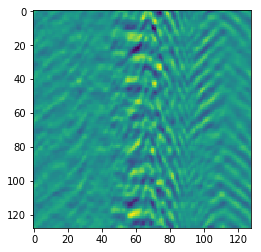

In [151]:
sum_img = masked_imgf[0,:,:,1] 
print(sum_img.min())
plt.imshow(sum_img)

tensor(-0.5000)

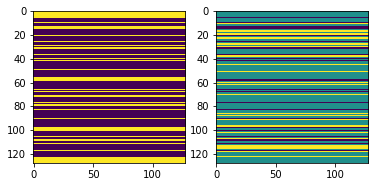

In [172]:
inv_mask = torch.ifft(torch.from_numpy(mask), 2)
plt.imshow(inv_mask[0,:,:,1], cmap='gray')

fft_mask_ = torch.rfft(inv_mask[0,:,:,0], 2, onesided=False)
fft_mask = torch.fft(inv_mask, 2)
plt.subplot(121)
plt.imshow(fft_mask[0,:,:,0])
plt.subplot(122)
plt.imshow(fft_mask_[:,:,0] - fft_mask[0,:,:,0])
(fft_mask_[:,:,0] - fft_mask[0,:,:,0]).min()

In [176]:
fft_mask.sum()

tensor(11264.)

In [ ]:
# # load image net
# from data_util.ft_data_loader import get_train_valid_loader, get_test_loader
# import matplotlib.pyplot as plt
# import numpy as np
# %matplotlib inline
# loader = get_test_loader('/Users/zizhao/work/data', 10, 128, num_workers=0, 
#                             keep_ratio=0.1, which_dataset='ImageNet', normalize=False)
# loader = iter(loader)
# data, label, kspace = loader.next()
# plt.figure()
# for i in range(len(data)):
#     plt.figure()

#     plt.subplot(121)
#     plt.imshow(data[i][0].numpy(), cmap='gray')
#     plt.subplot(122)
#     plt.imshow(kspace[i][1].numpy(), cmap='gray')

In [ ]:
from data.ft_data_loader.ft_data_loader import get_train_valid_loader, get_test_loader

loader = get_test_loader(100, 40, 32, keep_ratio=0.25, num_workers=0, 
                            which_dataset='MNIST', normalize=False, data_dir='/Users/zizhao/work/data')
loader = iter(loader)
data, label, kspace = loader.next()

for i in range(len(data)):
    plt.subplot(121)
    plt.imshow(data[i][0].numpy(), cmap='gray')
    plt.subplot(122)
    plt.imshow(kspace[i][0].numpy(), cmap='gray')

## Experiment a least-squares problem of kspace

In [ ]:
print('masked kspace', masked_mask_tensor.shape)
print('inversed masked kspace', inv_masked_mask_tensor.shape)
a = np.concatenate([masked_mask_tensor[0,:,:,0], masked_mask_tensor[0,:,:,1]], axis=1)
b = np.concatenate([inv_masked_mask_tensor[0,:,:,0], inv_masked_mask_tensor[0,:,:,1]], axis=1)
c = np.concatenate([d[0,:,:,0], d[0,:,:,1]], axis=1)
img_ten = im_tensor.view(1,h,w,1)
img_part = torch.zeros_like(img_ten)
img_f = torch.cat([img_ten, img_part],3)
dd = torch.fft(img_f,2)
full_imgf = torch.ifft(dd, 2)
full_img = full_imgf[:,:,:,0]

def _to_kspace(data):
    # data is in [h,2w]
    h,w = data.shape
    r = np.concatenate([data[:,:w//2][:,:,np.newaxis], data[:,w//2:][:,:,np.newaxis]],2)
    r = r[np.newaxis,:,:,:]
    return r

x = np.linalg.lstsq(a, b)
x, residuals, rank, s = x
res = np.matmul(a, x)

In [ ]:
# full image
plt.imshow(full_img[0], cmap='gray')
# test b
b_kspace = _to_kspace(b)
_b_img = torch.ifft(torch.from_numpy(b_kspace), 2)
plt.figure()
plt.imshow(_b_img[0,:,:,0], cmap='gray')
# test ax ~= b
res_kspace = _to_kspace(res)
_res_img = torch.ifft(torch.from_numpy(res_kspace), 2)
plt.figure()
plt.imshow(_res_img[0,:,:,0], cmap='gray') 

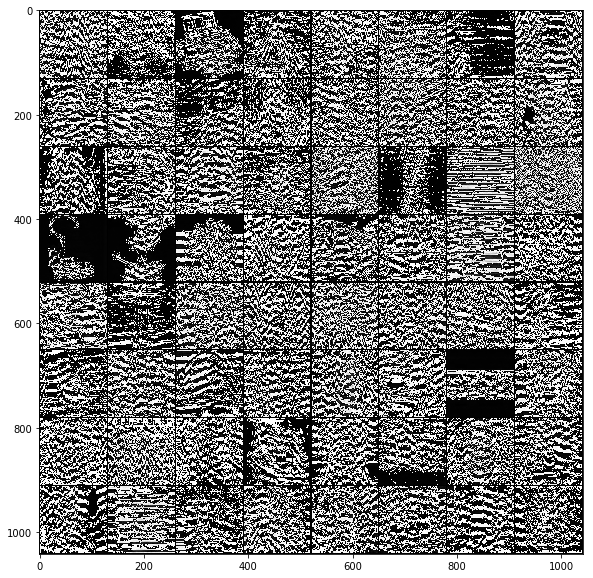

In [114]:
gt = Image.open('results/resnet_9blocks_residual/imagenet_resnet_9blocks_residual_gt.png')
res = Image.open('results/resnet_9blocks_residual/imagenet_resnet_9blocks_residual_resnet_residual.png')
difference = np.asarray(gt) - np.asarray(res)
plt.figure(figsize=(10,10))
plt.imshow(difference)